## Classical pre-processing 

In [160]:
import numpy as np
import scipy

# the size of the unitary which block encodes A
REG_SIZE = 3


def get_random_unitary(num_qubits, seed=4):
    np.random.seed(seed)
    X = np.random.rand(2**num_qubits, 2**num_qubits)
    U, s, V = np.linalg.svd(X)
    return U @ V.T


U_a = get_random_unitary(REG_SIZE)

A_dim = int(U_a.shape[0] / 2)
A = U_a[:A_dim, :A_dim]
print(A)

[[-0.05338002 -0.36103662 -0.54016489 -0.39026125]
 [-0.33304121  0.10648228  0.37346704 -0.33977916]
 [ 0.4167817  -0.75180519  0.17593867  0.20944773]
 [ 0.26891079 -0.05333795 -0.32668787 -0.33602829]]


Our modifications:

In [161]:
def generate_matrix_with_condition_number(size, condition_number, random_seed=None):
    """
    Generates a random matrix with the specified condition number.

    Parameters:
        size (int or tuple): Shape of the matrix (e.g., (m, n) or n for square).
        condition_number (float): Desired condition number.
        random_seed (int, optional): Random seed for reproducibility.
    
    Returns:
        np.ndarray: Matrix with the specified condition number.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Ensure size is a tuple
    if isinstance(size, int):
        size = (size, size)
    
    m, n = size

    # Generate random orthogonal matrices U and V
    U, _ = np.linalg.qr(np.random.randn(m, m))
    V, _ = np.linalg.qr(np.random.randn(n, n))

    # Create singular values with the desired condition number
    singular_values = np.linspace(condition_number, 1, min(m, n))

    # Construct the diagonal matrix of singular values
    Sigma = np.zeros((m, n))
    np.fill_diagonal(Sigma, singular_values)

    # Reconstruct the matrix
    A = U @ Sigma @ V.T

    return A

# Example Usage
A_int = generate_matrix_with_condition_number(size=(4, 4), condition_number=3, random_seed=42)

In [162]:
alpha = np.linalg.norm(A_int, ord=2)  # Spectral norm
A = A_int / (alpha)

In [163]:
I = np.eye(A.shape[0])
top_right_block = scipy.linalg.sqrtm(I - A @ A.T.conj())
bottom_left_block = scipy.linalg.sqrtm(I - A.T.conj() @ A)

U_a = np.block([[A, top_right_block],
[bottom_left_block, -1*A.T.conj()]])

In [164]:
print(A)
print(U_a)

[[ 0.05502668 -0.62585757  0.20559202  0.3181578 ]
 [-0.25116873 -0.08013233 -0.40416795 -0.40717143]
 [-0.41564533  0.47872581  0.10376737 -0.2329647 ]
 [ 0.46692363 -0.22178535  0.26395108 -0.53288816]]
[[ 0.05502668+0.00000000e+00j -0.62585757+0.00000000e+00j
   0.20559202+0.00000000e+00j  0.3181578 +0.00000000e+00j
   0.5115538 +8.95658486e-09j  0.19087606-4.22217599e-09j
   0.38926789-8.46540642e-09j -0.11014294+4.36298343e-09j]
 [-0.25116873+0.00000000e+00j -0.08013233+0.00000000e+00j
  -0.40416795+0.00000000e+00j -0.40717143+0.00000000e+00j
   0.19087606-4.22217599e-09j  0.73578225+1.99035351e-09j
  -0.15101044+3.99063217e-09j  0.02719236-2.05673079e-09j]
 [-0.41564533+0.00000000e+00j  0.47872581+0.00000000e+00j
   0.10376737+0.00000000e+00j -0.2329647 +0.00000000e+00j
   0.38926789-8.46540642e-09j -0.15101044+3.99063217e-09j
   0.57445896+8.00116416e-09j  0.16936234-4.12371774e-09j]
 [ 0.46692363+0.00000000e+00j -0.22178535+0.00000000e+00j
   0.26395108+0.00000000e+00j -0.53288

Make sure A's singular values are < 1

In [165]:
assert not (np.linalg.svd(A)[1] > 1).sum()

Define b-vector

In [166]:
b = np.ones(4)     # np.arange(A_dim)
b = b / np.linalg.norm(b)
print(b)

[0.5 0.5 0.5 0.5]


Verify that U_a is indeed unitary 

In [167]:
assert np.allclose(U_a @ U_a.T, np.eye(U_a.shape[0]), rtol=1e-5, atol=1e-6)

Calculate condition number $\kappa$ = max ($\frac{1}{\sigma_i}$)

In [168]:
kappa = max(1 / np.linalg.svd(A)[1])
print(kappa)


2.9999999999999987


Print out singular value decomposition

np.linalg.svd(A)[1]

## Quantum algorithm

In [169]:
#import classiq
#classiq.authenticate()

from classiq import *
from classiq.qmod.symbolic import floor
# classiq.authenticate()

@qfunc
def my_projector_controlled_phase(
    phase: CReal,
    proj_cnot: QCallable[QArray[QBit], QBit],
    state: QArray[QBit],
    aux: QBit,
) -> None:
    proj_cnot(state, aux)
    RZ(phase, aux)
    proj_cnot(state, aux)


@qfunc
def my_qsvt_step(
    phase_seq: CArray[CReal],
    index: CInt,
    u: QCallable[QArray[QBit]],
    state: QArray[QBit],
    aux: QBit,
):
    my_projector_controlled_phase(phase_seq[2 * index], proj_cnot_1, state, aux)
    u(state)
    my_projector_controlled_phase(
        phase_seq[2 * index + 1],
        proj_cnot_2,
        state,
        aux,
    )

    if_(
        condition=2 * index + 2 == phase_seq.len,
        then=lambda: IDENTITY(state),
        else_=lambda: invert(lambda: u(state)),
    )


@qfunc
def my_qsvt_step(
    phase1: CReal,
    phase2: CReal,
    proj_cnot_1: QCallable[QArray[QBit], QBit],
    proj_cnot_2: QCallable[QArray[QBit], QBit],
    u: QCallable[QArray[QBit]],
    state: QArray[QBit],
    aux: QBit,
):
    u(state)
    my_projector_controlled_phase(phase1, proj_cnot_2, state, aux)
    invert(lambda: u(state))
    my_projector_controlled_phase(phase2, proj_cnot_1, state, aux)


@qfunc
def my_qsvt(
    phase_seq: CArray[CReal],
    proj_cnot_1: QCallable[QArray[QBit], QBit],
    proj_cnot_2: QCallable[QArray[QBit], QBit],
    u: QCallable[QArray[QBit]],
    state: QArray[QBit],
    aux: QBit,
) -> None:
    H(aux)

    my_projector_controlled_phase(phase_seq[0], proj_cnot_1, state, aux)
    repeat(
        count=floor((phase_seq.len - 1) / 2),
        iteration=lambda index: my_qsvt_step(
            phase_seq[2 * index + 1],
            phase_seq[2 * index + 2],
            proj_cnot_1,
            proj_cnot_2,
            u,
            state,
            aux,
        ),
    )

    if_(
        condition=phase_seq.len % 2 == 1,
        then=lambda: IDENTITY(state),
        else_=lambda: (
            u(state),
            my_projector_controlled_phase(
                phase_seq[phase_seq.len - 1],
                proj_cnot_2,
                state,
                aux,
            ),
        ),
    )

    H(aux)


### Matrix inversion algorithm

In [170]:
@qfunc
def my_qsvt_inversion(
    phase_seq: CArray[CReal],
    u: QCallable[QArray[QBit]],
    state: QArray[QBit],
    aux: Output[QBit],
) -> None:
    allocate(1, aux)

    def _projector_cnot(state: QArray[QBit], aux: QBit):
        X(state[state.len - 1])
        CX(state[state.len - 1], aux)
        X(state[state.len - 1])

    my_qsvt(
        phase_seq,
        lambda arg0, arg1: _projector_cnot(arg0, arg1),
        lambda arg0, arg1: _projector_cnot(arg0, arg1),
        u,
        state,
        aux,
    )


Get the phase sequence for the inverse function

In [171]:
import pyqsp

pg = pyqsp.poly.PolyOneOverX()
pcoefs = pg.generate(epsilon=0.05, kappa=kappa)

b=36, j0=16
[PolyOneOverX] minimum [-3.86285345] is at [-0.1873238]: normalizing
[PolyOneOverX] bounding to 0.5
[pyqsp.PolyOneOverX] pcoefs=[ 0.00000000e+00  4.65942352e+00  0.00000000e+00 -8.14718444e+01
  0.00000000e+00  9.19393485e+02  0.00000000e+00 -7.47721753e+03
  0.00000000e+00  4.61734011e+04  0.00000000e+00 -2.21848884e+05
  0.00000000e+00  8.37506659e+05  0.00000000e+00 -2.48959793e+06
  0.00000000e+00  5.81572924e+06  0.00000000e+00 -1.06215171e+07
  0.00000000e+00  1.50356943e+07  0.00000000e+00 -1.62737905e+07
  0.00000000e+00  1.31818687e+07  0.00000000e+00 -7.72048488e+06
  0.00000000e+00  3.08371477e+06  0.00000000e+00 -7.50823295e+05
  0.00000000e+00  8.40103402e+04]


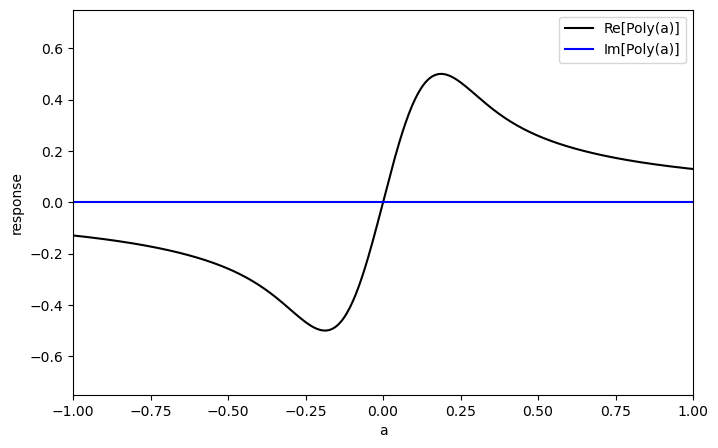

In [172]:
import numpy as np
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

poly = Polynomial(pcoefs)

# choosing 'z' this basis since P(1)=1 and won't to avoid the QSP basis change. Anyway, we are not measuring directly this qubit.
ang_seq = QuantumSignalProcessingPhases(
    poly, signal_operator="Wx", method="laurent", measurement="x", tolerance = 0.0005
)
pyqsp.response.PlotQSPResponse(ang_seq, signal_operator="Wx", measurement="x")


### Adjusting phase conventions.
There conventions by which the pyqsp package calculates the the phases are different from the phases we need for this qsvt circuit. The following block takes care for them.

In [173]:


# change the R(x) to W(x), as the phases are in the W(x) conventions
phases = np.array(ang_seq)
phases[1:-1] = phases[1:-1] - np.pi / 2
phases[0] = phases[0] - np.pi / 4
phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

# verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
phases = -2 * phases

### Using the inversion function to solve linear system

In [174]:
@qfunc
def main(
    state: Output[QNum],
    block: Output[QBit],
    aux: Output[QBit],
) -> None:
    full_state = QArray("full_state")

    prepare_amplitudes(b.tolist(), 0, state)

    allocate(1, block)
    bind([state, block], full_state)

    my_qsvt_inversion(
        phase_seq=list(phases),
        u=lambda arg0: unitary(
            # Here we can just use the transpose of A as is it real valued
            elements=U_a.T.tolist(),
            target=arg0,
        ),
        state=full_state,
        aux=aux,
    )

    bind(full_state, [state, block])

Synthesizing and Executing the circuit using state-vector simulator, to get $x = A^{-1}b$

In [175]:
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)

# convert the functions to a qmod model
qmod = create_model(main)

# we will want to execute this qmod on a state-vector simulator:
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)
qmod = set_execution_preferences(qmod, execution_preferences)

write_qmod(qmod, name="qsvt_matrix_inversion", decimal_precision=15)

In [176]:
qprog = synthesize(qmod)
show(qprog)
result = execute(qprog).result_value()

ClassiqAPIError: 
	ReportedUnitaryGateError: Input matrix of UnitaryGate must be unitary: [[(0.0550266819005757+0j), (-0.25116873036128423+0j), (-0.4156453262330429+0j), (0.46692362945094257+0j), (0.6233872366912031+5.985012561074423e-09j), (0.35054462455898766-8.66079854381093e-09j), (-0.17359145901942669+3.2168615072168626e-09j), (-0.038476549838988114+3.5492887527432683e-09j)], [(-0.6258575667073183+0j), (-0.08013232750933078+0j), (0.478725810291786+0j), (-0.22178534712802894+0j), (0.35054462455898777-8.66079854381093e-09j), (0.3763285907211326+1.253287785966015e-08j), (0.15143436676606076-4.6550594794981905e-09j), (0.18993910920005874-5.136108662703469e-09j)], [(0.20559201681167785+0j), (-0.4041679497088137+0j), (0.10376737289729332+0j), (0.2639510836671341+0j), (-0.17359145901942677+3.2168615072168626e-09j), (0.15143436676606067-4.6550594794981905e-09j), (0.8097756545878999+1.7290185861791818e-09j), (-0.07168944105535466+1.9076936347561983e-09j)], [(0.31815779697616553+0j), (-0.40717143489038554+0j), (-0.23296470139335396+0j), (-0.5328881575133753+0j), (-0.038476549838988065+3.5492887527432703e-09j), (0.18993910920005883-5.1361086627034705e-09j), (-0.07168944105535473+1.907693634756199e-09j), (0.5933363399196375+2.104832783857749e-09j)], [(0.5115537957374885+8.956584861062953e-09j), (0.1908760591523903-4.222175990959548e-09j), (0.3892678854284246-8.465406415803756e-09j), (-0.11014293805728426+4.362983428836858e-09j), (-0.0550266819005757+0j), (0.6258575667073183+0j), (-0.20559201681167785+0j), (-0.31815779697616553+0j)], [(0.19087605915239025-4.222175990959548e-09j), (0.7357822524569119+1.9903535080802647e-09j), (-0.15101043949418919+3.990632174759486e-09j), (0.027192355355387964-2.056730792812824e-09j), (0.25116873036128423+0j), (0.08013232750933078+0j), (0.4041679497088137+0j), (0.40717143489038554+0j)], [(0.38926788542842466-8.465406415803758e-09j), (-0.15101043949418907+3.990632174759486e-09j), (0.5744589625652138+8.001164159820906e-09j), (0.16936234066093903-4.123717743253503e-09j), (0.4156453262330429+0j), (-0.478725810291786+0j), (-0.10376737289729332+0j), (0.23296470139335396+0j)], [(-0.11014293805728427+4.362983428836858e-09j), (0.027192355355388054-2.056730792812824e-09j), (0.16936234066093894-4.123717743253503e-09j), (0.5810328111602533+2.125321726482912e-09j), (-0.46692362945094257+0j), (0.22178534712802894+0j), (-0.2639510836671341+0j), (0.5328881575133753+0j)]]

Error identifier: E96249472-EA3D-47E9-9342-6B11B87668E7.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack


### Post processing

In [ ]:
def parse_results(result):
    parsed_state_vector = result.parsed_state_vector

    d = {
        int(parsed_state["state"]): parsed_state.amplitude
        for parsed_state in parsed_state_vector
        if parsed_state["aux"] == parsed_state["block"] == 0.0
    }

    values = np.array([d[i] for i in range(len(d))])
    global_phase = np.angle(values)[0]
    values = np.real(values / np.exp(1j * global_phase))
    normalization = np.linalg.norm(
        [
            parsed_state.amplitude
            for parsed_state in parsed_state_vector
            if parsed_state["block"] == 0.0
        ]
    )
    computed_x = values / normalization
    return computed_x

In [ ]:
parsed_state_vector = result.parsed_state_vector

d = {
    parsed_state["state"]: parsed_state.amplitude
    for parsed_state in parsed_state_vector
    if parsed_state["aux"] == parsed_state["block"] == 0.0
}

In [ ]:
computed_x = parse_results(result)
print(computed_x)

[ 0.14711247 -0.02612048 -0.04692567  0.08213192]


Compare to expectation:

In [ ]:
expected_x = 1 / (2 * kappa) * (np.linalg.inv(A) @ b)
print(expected_x)

assert np.allclose(computed_x, expected_x, rtol=0.2)

[ 0.0226243   0.01729465 -0.01012794 -0.01551759]


AssertionError: 